# Modified Rouvein Algorithm
- Focus on Main Components

### 1) Data Preparation

In [28]:
# Import Modules
import pandas as pd
import numpy as np
import pickle
import math
import sqlite3
# Import Data
with open('/data1/StackOverflow/Tag_Analysis/df_tags_2023.pickle', 'rb') as fr:
    df_tags = pickle.load(fr)
# Slice preGPT tags.
preGPT = df_tags[(df_tags['creation_date'] > '2021-09-01') & 
        (df_tags['creation_date'] < '2023-09-01')]
# Preprocess
from nltk import FreqDist
def wc(text):
    """
    Cleaning function to be used with our first wordcloud
    """
    
    if text:
        tags = text.replace('><',' ')
        tags = tags.replace('-','')
        tags = tags.replace('.','DOT')
        tags = tags.replace('c++','Cpp')
        tags = tags.replace('c#','Csharp')
        tags = tags.replace('>','')
        return tags.replace('<','')
    else:
        return 'None'
    
def clean_tags(text):
    """
    Cleaning function for tags
    """
    
    if text:
        tags = text.replace('><',' ')
        tags = tags.replace('>','')
        return tags.replace('<','')
    else:
        return 'None'
    
def tag_freq(data):
    tags = data['tags'].str.replace('[\["\]]', '', regex=True)
    tags = [tag for i in tags.apply(lambda x: wc(x)) for tag in i.split(', ')]
    result = FreqDist(tags)
    return result
# Tags Preprocessing
preGPT['tags'] = preGPT['tags'].str.replace('[\["\]]', '', regex=True)
preGPT['tags'] = preGPT['tags'].str.replace('c#','Csharp')
preGPT['tags'] = preGPT['tags'].str.replace('c++','Cpp')
preGPT['tags'] = preGPT['tags'].str.replace('.','DOT')
preGPT['tags'] = preGPT['tags'].str.replace('><',' ')
preGPT['tags'] = preGPT['tags'].str.replace('>','')
preGPT['tags'] = preGPT['tags'].str.replace('-','')
preGPT['tags'] = preGPT['tags'].str.replace('"', '')

preGPT = preGPT.reset_index(drop = True)
preGPT['tags'] = preGPT['tags'].str.replace(',', ' ')
preGPT['tags'] = preGPT['tags'].str.split() 

# Extract tag pairs
from collections import defaultdict
from itertools import combinations
tag_pairs = defaultdict(int)
for tags in preGPT['tags']:
    for pair in combinations(tags, 2):
        tag_pairs[tuple(sorted(pair))] += 1
tag_pairs_df = pd.DataFrame(tag_pairs.items(), columns = ['pair', 'count'])

/tmp/ipykernel_2108410/2311152271.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preGPT['tags'] = preGPT['tags'].str.replace('[\["\]]', '', regex=True)
/tmp/ipykernel_2108410/2311152271.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preGPT['tags'] = preGPT['tags'].str.replace('c#','Csharp')
/tmp/ipykernel_2108410/2311152271.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

### 2) Network Development

In [29]:
import networkx as nx
# Create a graph
G = nx.Graph()
# Add edges with weights
for pair, count in tag_pairs.items():
    G.add_edge(pair[0], pair[1], weight=count)

# Get the nodes with degree 1
nodes_to_remove = [node for node in G.nodes() if G.degree(node) == 1] # 1133개.
# Remove these nodes
G.remove_nodes_from(nodes_to_remove)

In [30]:
len(nodes_to_remove)

1109

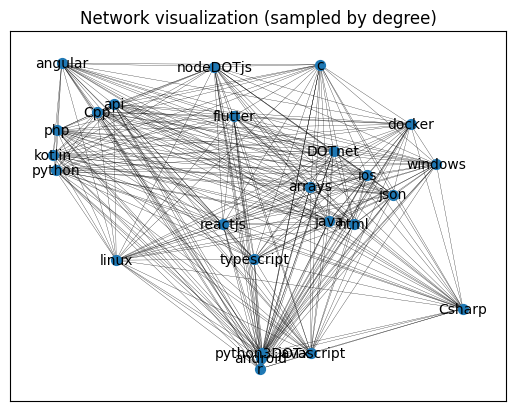

In [31]:
import heapq
import matplotlib.pyplot as plt
# Get a list of all nodes in the graph
nodes = list(G.nodes())

# Calculate the degree of each node
degrees = [(node, G.degree(node)) for node in nodes]

# Create a new graph with the sampled nodes
# Select the top 100 nodes by degree
sample_nodes = heapq.nlargest(25, degrees, key=lambda x: x[1])
sample_nodes = [node for node, degree in sample_nodes if node in G]
sample_G = G.subgraph(sample_nodes)

# Visualize the sampled graph
pos = nx.random_layout(sample_G)#nx.spring_layout(sample_G)
nx.draw_networkx_nodes(sample_G, pos, nodelist=sample_nodes, node_size=50)
nx.draw_networkx_edges(sample_G, pos, width=0.2)
nx.draw_networkx_labels(sample_G, pos, font_size=10)
plt.title("Network visualization (sampled by degree)")
plt.show()

### 3) Louvain Community Detection

In [32]:
import community as community_louvain
# Perform Louvain community detection
partition = community_louvain.best_partition(G, weight='weight')
# Print the communities
for tag, community_id in partition.items():
    print(f"Tag: {tag}, Community: {community_id}")

Tag: nodeDOTjs, Community: 0
Tag: reactjs, Community: 0
Tag: express, Community: 0
Tag: axios, Community: 0
Tag: refreshtoken, Community: 0
Tag: r, Community: 1
Tag: shiny, Community: 1
Tag: installation, Community: 1
Tag: java, Community: 2
Tag: compilation, Community: 3
Tag: project, Community: 3
Tag: operatorkeyword, Community: 3
Tag: firebase, Community: 14
Tag: nuxtDOTjs, Community: 0
Tag: firebasehosting, Community: 14
Tag: dataDOTtable, Community: 1
Tag: discordDOTpy, Community: 1
Tag: python, Community: 1
Tag: texttospeech, Community: 1
Tag: frontend, Community: 0
Tag: reactsimplemaps, Community: 0
Tag: wordpress, Community: 5
Tag: wordpresstheming, Community: 5
Tag: elementor, Community: 5
Tag: javascript, Community: 0
Tag: googleplacesapi, Community: 14
Tag: matrix, Community: 1
Tag: plot, Community: 1
Tag: pandas, Community: 1
Tag: go, Community: 3
Tag: visualstudiocode, Community: 3
Tag: interface, Community: 3
Tag: gettersetter, Community: 3
Tag: typehinting, Community: 1


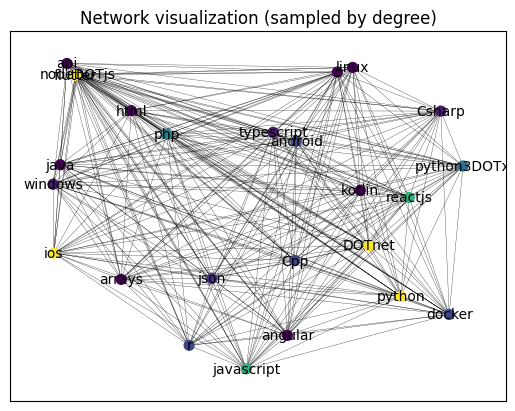

In [33]:
import heapq
import matplotlib.pyplot as plt

# Visualize the sampled graph
pos = nx.random_layout(sample_G)
node_colors = []
for node in sample_G.nodes():
    #community_id = partition[node]
    node_colors.append(partition[node])

nx.draw_networkx_nodes(sample_G, pos, nodelist=sample_nodes, node_size=50, node_color=node_colors)
nx.draw_networkx_edges(sample_G, pos, width=0.2)
nx.draw_networkx_labels(sample_G, pos, font_size=10)
plt.title("Network visualization (sampled by degree)")
plt.show()

### 4) Convert to DataFrame

In [34]:
# Initialize an empty dictionary to store the partition
partition_dict = {}
# Iterate over the partition and store it in the dictionary
for tag, community_id in partition.items():
    if community_id not in partition_dict:
        partition_dict[community_id] = []
    partition_dict[community_id].append(tag)

# Convert the dictionary to a DataFrame
partition_df = pd.DataFrame(list(partition_dict.items()), columns=['Community', 'Tags'])

In [35]:
df_partition = pd.DataFrame.from_dict(data = partition, orient = 'index').reset_index()
df_partition.columns = ['tag', 'community']
df_partition

,tag,community
0,nodeDOTjs,0
1,reactjs,0
2,express,0
3,axios,0
4,refreshtoken,0
...,...,...
48080,externalassemblies,3
48081,taffyDOTjs,0
48082,swintransformer,1
48083,httpupload,5


In [36]:
df_partition.groupby('community')['tag'].count()

community
0     7246
1     7797
2     4547
3     6986
4       11
5     3733
6     3165
7     1011
8      422
9     4825
10     199
11     643
12     310
13       5
14    5982
15       4
16     187
17     984
18      28
Name: tag, dtype: int64

In [37]:
df_partition[df_partition['community'] == 0]

,tag,community
0,nodeDOTjs,0
1,reactjs,0
2,express,0
3,axios,0
4,refreshtoken,0
...,...,...
48058,offscreentabs,0
48064,amslidemenu,0
48065,sipsorcery,0
48066,ontrack,0


### 4) Top 10 tags that compose each community

In [38]:
# Import Modules
import pandas as pd
import numpy as np
import pickle
import math
import sqlite3
# Import Data
with open('/data1/StackOverflow/Tag_Analysis/df_tags_2023.pickle', 'rb') as fr:
    df_tags = pickle.load(fr)
# Slice preGPT tags.
preGPT = df_tags[(df_tags['creation_date'] > '2021-09-01') & 
        (df_tags['creation_date'] < '2023-09-01')]
# Preprocess
from nltk import FreqDist
def wc(text):
    """
    Cleaning function to be used with our first wordcloud
    """
    
    if text:
        tags = text.replace('><',' ')
        tags = tags.replace('-','')
        tags = tags.replace('.','DOT')
        tags = tags.replace('c++','Cpp')
        tags = tags.replace('c#','Csharp')
        tags = tags.replace('>','')
        return tags.replace('<','')
    else:
        return 'None'
    
def clean_tags(text):
    """
    Cleaning function for tags
    """
    
    if text:
        tags = text.replace('><',' ')
        tags = tags.replace('>','')
        return tags.replace('<','')
    else:
        return 'None'
    
def tag_freq(data):
    tags = data['tags'].str.replace('[\["\]]', '', regex=True)
    tags = [tag for i in tags.apply(lambda x: wc(x)) for tag in i.split(', ')]
    result = FreqDist(tags)
    return result
# Tags Preprocessing
preGPT['tags'] = preGPT['tags'].str.replace('[\["\]]', '', regex=True)
preGPT['tags'] = preGPT['tags'].str.replace('c#','Csharp')
preGPT['tags'] = preGPT['tags'].str.replace('c++','Cpp')
preGPT['tags'] = preGPT['tags'].str.replace('.','DOT')
preGPT['tags'] = preGPT['tags'].str.replace('><',' ')
preGPT['tags'] = preGPT['tags'].str.replace('>','')
preGPT['tags'] = preGPT['tags'].str.replace('-','')
#preGPT['tags'] = preGPT['tags'].str.replace('"', '')

preGPT = preGPT.reset_index(drop = True)

/tmp/ipykernel_2108410/735405123.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preGPT['tags'] = preGPT['tags'].str.replace('[\["\]]', '', regex=True)
/tmp/ipykernel_2108410/735405123.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preGPT['tags'] = preGPT['tags'].str.replace('c#','Csharp')
/tmp/ipykernel_2108410/735405123.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [39]:
all_tags = tag_freq(preGPT)
all_tags = pd.DataFrame(all_tags, index = ['tags']).transpose().reset_index()

In [40]:
all_tags = all_tags.rename(columns = {'index': 'tag',
                           'tags': 'tag_count'})
all_tags

,tag,tag_count
0,nodeDOTjs,82196
1,reactjs,155462
2,express,18287
3,axios,8260
4,refreshtoken,369
...,...,...
49406,taffyDOTjs,1
49407,swintransformer,1
49408,httpupload,1
49409,microsoftDOTwebDOTadministration,1


In [41]:
df_merge = pd.merge(df_partition, all_tags, on = 'tag')
df_merge

,tag,community,tag_count
0,nodeDOTjs,0,82196
1,reactjs,0,155462
2,express,0,18287
3,axios,0,8260
4,refreshtoken,0,369
...,...,...,...
48080,externalassemblies,3,1
48081,taffyDOTjs,0,1
48082,swintransformer,1,1
48083,httpupload,5,1


In [42]:
df_merge[df_merge['tag'] == 'python']

,tag,community,tag_count
17,python,1,425466


In [43]:
top5each = df_merge.groupby('community').apply(lambda group: group.nlargest(10, 'tag_count')).reset_index(drop=True)

In [44]:
top5each

,tag,community,tag_count
0,javascript,0,287722
1,reactjs,0,155462
2,html,0,107071
3,nodeDOTjs,0,82196
4,css,0,78070
...,...,...,...
174,autodeskbim360,18,170
175,forge,18,157
176,autodeskdesignautomation,18,149
177,autodeskdatamanagement,18,49


In [45]:
df_merge.groupby('community')['tag_count'].sum()

community
0     1954308
1     1979388
2      605066
3      757086
4         675
5      615912
6      492414
7      207793
8       90210
9      636050
10      15888
11      37651
12      39535
13         72
14     743527
15         10
16      11277
17      84048
18       3131
Name: tag_count, dtype: int64

In [60]:
top5each[top5each['community'] == 18]

,tag,community,tag_count
169,autodeskforge,18,1150
170,autodeskviewer,18,458
171,autodesk,18,292
172,revitapi,18,251
173,autodeskmodelderivative,18,186
174,autodeskbim360,18,170
175,forge,18,157
176,autodeskdesignautomation,18,149
177,autodeskdatamanagement,18,49
178,autodeskinventor,18,44


In [61]:
#import pickle
#with open(file = 'louvain_community_modified.pickle', mode = 'wb') as file:
#    pickle.dump(df_merge, file)

In [ ]:
import pickle
with open(file = 'louvain_community_modified.pickle', mode = 'rb') as file:
    data = pickle.load(file)